In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
import random
from Helper.ImportDatasets import df_epsilon
from Method.calculate_distribution_a import distribution_a

# Introduction
In this notebook we improve the calculation of the distribution by making the bins that we calculate the distribution for dynamic.

They adapt, say we already know an area is 0 from the previous distribution, then we don't need to calculate it again. Instead we pick the area where the previous distribution was positive and make 400 new bins there.

In [165]:
"""
We pick sigma, delta, network and number of samples. Although delta doesn't matter much as the region of a we use is large enough to quickly find a solution where prob = 1
"""
def run(network, ani = False, shuffle = False, step_size_a = 0.001, sigma = 0.05, n_samples = 1000, n_a_samples = 100, uncertainty = 0.002):
    delta = 0.05
    
    # Get the network and test set, then split the images
    df_for_network = df_epsilon[df_epsilon['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]
    
    # We find the distribution of 'a' for the following bins
    a = torch.arange(step_size_a,0.4,step_size_a)
    
    # We keep track of the distributions of 'a' and its max probability
    distributions_of_a = []
    
    # We keep track of what bins of 'a' we use
    a_bins = []
    
    # Initialize D (dataset) and the default value to put in if we don't find elligible epsilons
    D = torch.tensor([[],[]],dtype=torch.float32)
    default = torch.tensor([[0],[0.4]],dtype=torch.float32)
    
    if shuffle:
        random.shuffle(df_per_image)
    
    for i,image in enumerate(df_per_image):
        # We put in the default value first and then change it to the lower and upper bound of the image
        D = torch.cat((D,default),dim=1)
        
        # unsat means epsilon >, thus lower bound
        lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values)
        # sat means epsilon <, thus upper bound
        upper_bound = np.min(image[image['result']=='sat']['epsilon'].values)
        D[0,-1] = lower_bound
        D[1,-1] = upper_bound
        
        print(f"image {i+1}")
        
        # Sample in our bins of 'a', 100 samples are taken per bin
        a_samples = torch.rand(n_a_samples,*a.shape)*step_size_a+a
        # We calculate the distribution of each sample
        distr = distribution_a(a_samples,D,sigma,n_samples)
        max_distr = torch.max(distr)
        distributions_of_a.append(distr)
        a_bins.append(a)
        
        # If the distribution of 'a' becomes too peaked to fit in the range of a that has been given we are also satisfied as we know 'a' is in a small enough region
        if torch.isnan(max_distr):
           distributions_of_a.pop()
           a_bins.pop()
           print('found: region is too small')
           break
        
        # We adapt the area in which we search for 'a' based on the distribution
        indices = torch.where(distr == 0)[0]
        # Split into left and right arrays
        split_arrays = np.split(indices,torch.where(torch.diff(indices) != 1)[0]+1)
        # Check wether left and right arrays exist
        if len(split_arrays) == 1:
            arr = split_arrays[0]
            if arr.shape[0] == 0:
                left_bound_ind = 0
                right_bound_ind = -1
            elif torch.min(arr) == 0:
                left_bound_ind = torch.max(arr)
                right_bound_ind = -1
            else:
                left_bound_ind = 0
                right_bound_ind = torch.min(arr)
        elif len(split_arrays) == 2:
            left_bound_ind = torch.max(split_arrays[0])
            right_bound_ind = torch.min(split_arrays[1])
        else:
            print('error? 2')
            print(split_arrays)
        
        # We update the bounds
        left_bound = a[left_bound_ind]
        right_bound = a[right_bound_ind]
        
        # We check if the required uncertainty has been reached
        if right_bound-left_bound < 2*uncertainty:
            print('found: uncertainty reached')
            break
        
        # We check if we have attained a probability of at least 1-delta
        if max_distr > 1-delta:
            print('found')
            break
        
        # We update the range of 'a' we search in
        step_size_a = (right_bound-left_bound)/400
        a = torch.arange(left_bound,right_bound,step_size_a)
        
    
    if ani:
        fig, ax = plt.subplots()
    
        ax.set_ylim(0, 0.1)
        ax.set_xlim(0,0.2)
        line, = ax.plot(a, np.tile(0,len(a)))
        
        
        def animate(i):
            line.set_ydata(distributions_of_a[i])  # update the data.
            line.set_xdata(a_bins[i])
            return line,
        
        
        ani = animation.FuncAnimation(
            fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)
        
        # To save the animation, use e.g.
        #
        ani.save(network+".gif")
    
    return distributions_of_a, a_bins

image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
found: region is too small


C:\Users\lkiel\AppData\Local\Temp\ipykernel_2684\2643006473.py:114: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=26.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


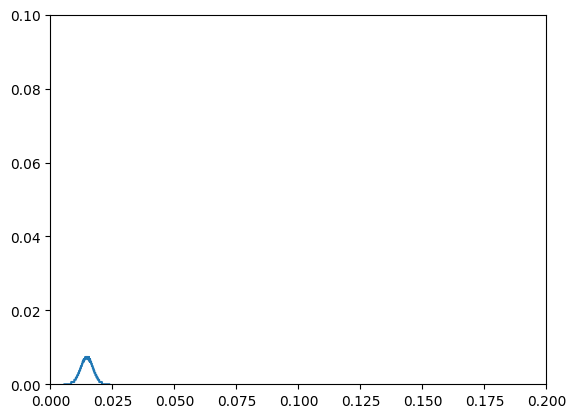

In [160]:
network = df_epsilon['network'].unique()[0]
distr, a_bins = run(network, ani=True)

In [166]:
# How much does the random sampling matter?
network = 'mnist-net'

final_distr = []
final_bins = []
for i in range(10):
    distr, bins = run(network, ani=False, shuffle = True)
    temp_distr = distr[-1].numpy()
    temp_bins = bins[-1].numpy()
    final_distr.append(temp_distr)
    final_bins.append(temp_bins)
    print(f"{i+1}/10 done")

# save the files
np.save('final_distr_notebook_4.0.npy',np.array(final_distr))
np.save('final_bins_notebook_4.0.npy',np.array(final_bins))

image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
image 29
found: region is too small
1/10 done
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
found: region is too small
2/10 done
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
found: region is too small
3/10 done
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 1

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

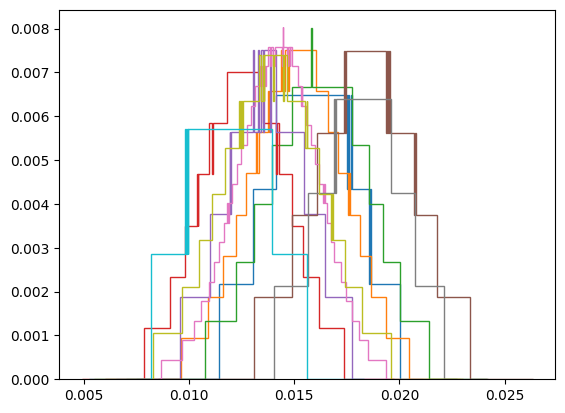

In [175]:
for i in range(10):
    last_bin_edge = torch.tensor([2*final_bins[i][-1]-final_bins[i][-2]])
    plt.stairs(final_distr[i],torch.cat((torch.tensor(final_bins[i]),last_bin_edge)))

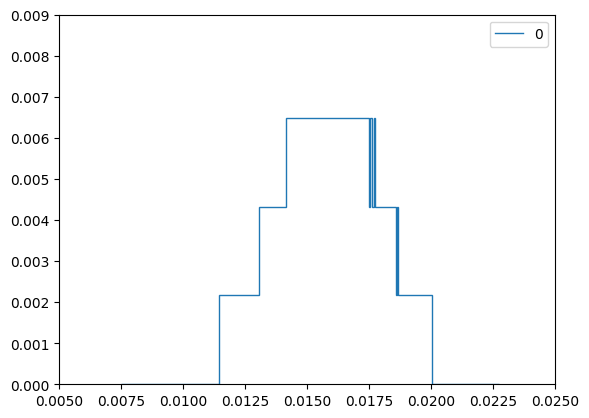

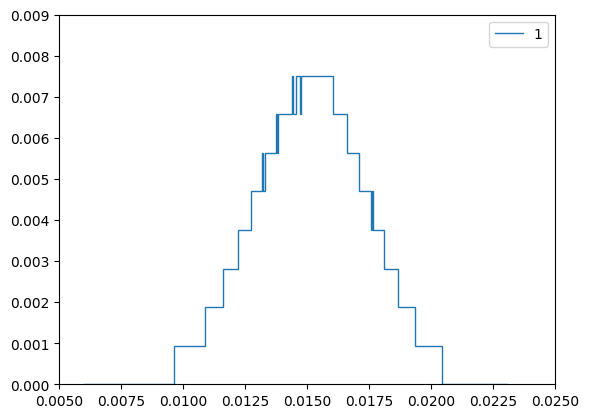

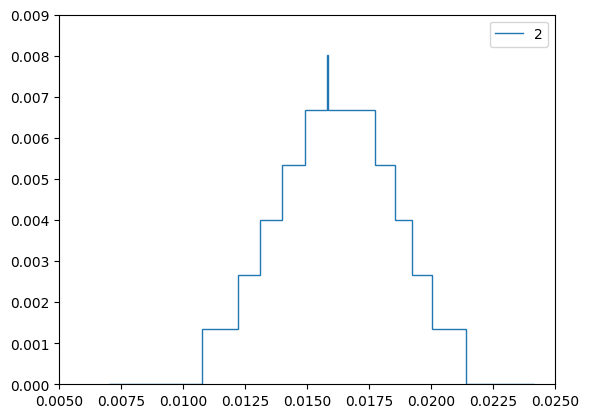

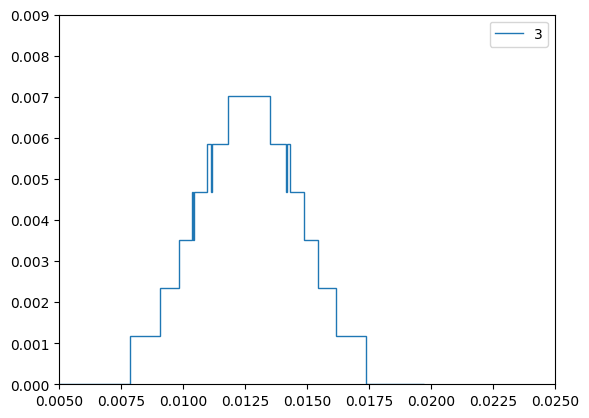

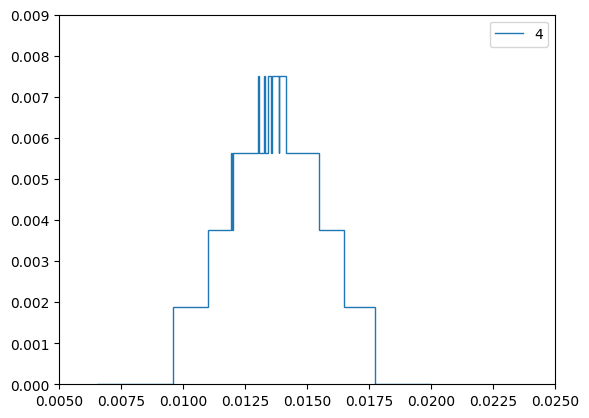

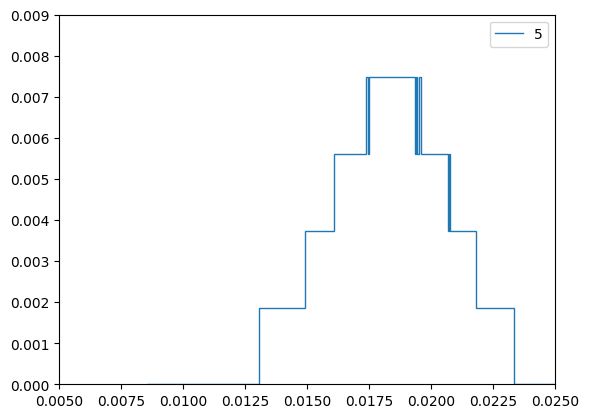

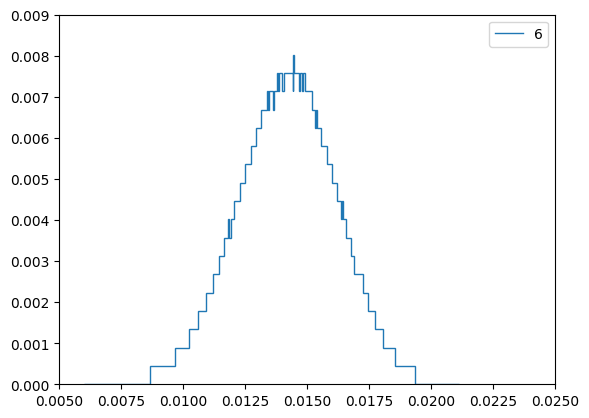

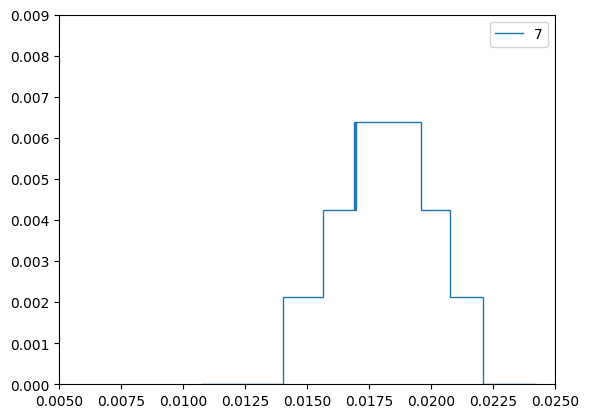

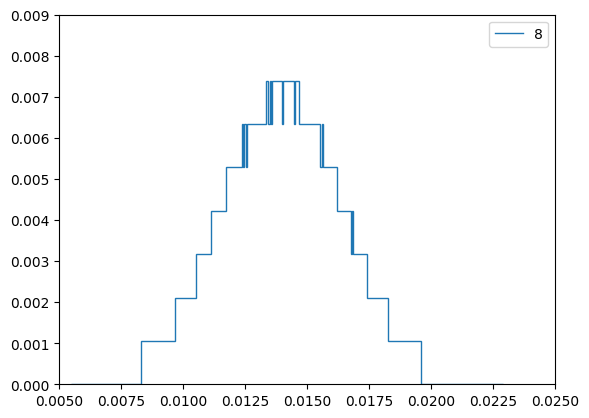

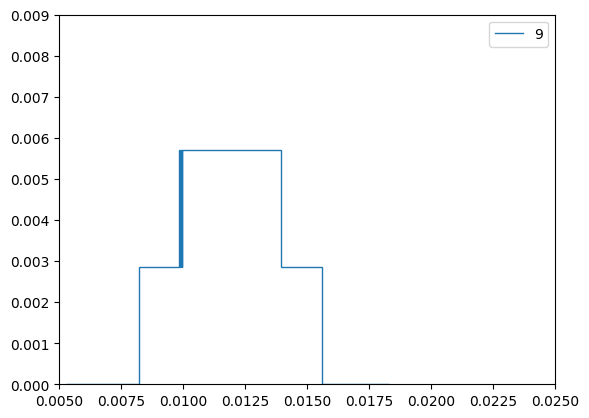

In [177]:
for i in range(10):
    fig, ax = plt.subplots()
    ax.set_ylim(0, 0.009)
    ax.set_xlim(0.005,0.025)
    last_bin_edge = torch.tensor([2*final_bins[i][-1]-final_bins[i][-2]])
    ax.stairs(final_distr[i],torch.cat((torch.tensor(final_bins[i]),last_bin_edge)), label = str(i))
    ax.legend()

In [179]:
print(final_distr[-1])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.002849   0.002849   0.002849   0.002849   0.002849   0.002849
 0.002849   0.002849   0.002849   0.002849   0.002